In [12]:
import ipywidgets as widgets
from IPython.display import display
import numpy as np
import osmnx as ox
import radar
from radar import RadarClient
import random

initialize radar geofence object

In [13]:
SECRET_KEY = "prj_live_sk_df80bb59ade3340d72bf15933e50e2b8a5e34104"
radar = RadarClient(SECRET_KEY)

# create a geofence
data = {
    "description": "Example Store",
    "type": "circle",
    "coordinates": [-73.98706, 40.7041029],
    "radius": 100,
    "tag": "store",
    "externalId": "141", #id needs to be changed each time we create a geofence object
}
new_geofence = radar.geofences.create(data=data)

functions that convert coordinates to address and vice versa

Please note that those functions aren't always accurate/correct when switching from coordinates to address and vice versa

In [14]:
def convert_coord_to_address(G,mp):
    d = G.nodes[mp]
    address = radar.geocode.reverse(coordinates=(d['y'],d['x']))[0]
    return(address)
    
def convert_address_to_node(address,G):
    address = radar.geocode.forward(query=address)[0]
    min_dist = 1000000
    closest_node = 0
    for node in G.nodes:#search for closest node in graph G by coordinates
        node_data = G.nodes[node]
        dist = (node_data['y'] -address.latitude)**2 +(node_data['x'] -address.longitude)**2 
        if dist < min_dist:
            min_dist = dist
            closest_node = node
    return closest_node

function that finds best meeting point best on criteria

In [15]:
def get_mp(orig1,orig2,dest,G,G2,walking_more=False,get_to_dest_faster=True,min_dist_3 = 500):
    min_time = 1000000
    min_middle = -1
    top_3_solutions = []
    if walking_more:#as of now the reduce gas means that the passanger has to walk more
        walk_limit = 2500
    else:
        walk_limit = 1000
    for i in range(len(list(G))):
        try:
            mp = list(G)[i]
            route1 = ox.shortest_path(G, orig1, mp, weight="travel_time")
            route2 = ox.shortest_path(G2, orig2, mp, weight="travel_time")
            route3 = ox.shortest_path(G, mp, dest, weight="travel_time")

            route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, "travel_time")))
            route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G2, route2, "travel_time")))
            route3_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route3, "travel_time")))

            route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G2, route2, "length")))
            route3_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route3, "length")))
            if route2_length <= walk_limit and route3_length >= min_dist_3:
                # min_dist_3 makes sure that meeting point won't be somewhere extemely near destination point 
                if get_to_dest_faster:
                    total_time = max(route1_time, route2_time) + route3_time
                else:
                    total_time = max(route1_time ,route2_time)
                if len(top_3_solutions) < 3:
                    top_3_solutions.append((mp,total_time))
                else:
                    top_3_solutions.sort(key=lambda a: a[1])
                    if total_time < top_3_solutions[2][1]:
                        top_3_solutions.remove(top_3_solutions[2])
                        top_3_solutions.append((mp,total_time))
        except Exception as e:
            pass
    print(top_3_solutions)
    return top_3_solutions

In [16]:
def get_mp_single(orig1,orig2,dest,G,G2,user="driver",cond_for_user=False,get_to_dest_faster=True,min_dist_3 = 500):
    min_time = 1000000
    min_middle = -1
    min_obj = 1000000
    top_200_solutions = []
    random.seed(0)
    potential_mps = random.sample(list(G), 500)
    for i in range(len(potential_mps)):
        try:
            mp = list(G)[i]
            route1 = ox.shortest_path(G, orig1, mp, weight="travel_time")
            route2 = ox.shortest_path(G2, orig2, mp, weight="travel_time")
            route3 = ox.shortest_path(G, mp, dest, weight="travel_time")

            route1_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, "travel_time")))
            route2_time = int(sum(ox.utils_graph.get_route_edge_attributes(G2, route2, "travel_time")))
            route3_time = int(sum(ox.utils_graph.get_route_edge_attributes(G, route3, "travel_time")))

            route1_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route1, "length")))
            route2_length = int(sum(ox.utils_graph.get_route_edge_attributes(G2, route2, "length")))
            route3_length = int(sum(ox.utils_graph.get_route_edge_attributes(G, route3, "length")))
            
            if user=="driver" and cond_for_user and route3_length >= min_dist_3:
                # min_dist_3 makes sure that meeting point won't be somewhere extemely near destination point 
                if get_to_dest_faster:
                    total_time = max(route1_time, route2_time) + route3_time
                else:
                    total_time = max(route1_time ,route2_time)
                total_objective = total_time + route1_time
                if len(top_200_solutions) < 200:
                    top_200_solutions.append((mp,total_objective))
                else:
                    top_200_solutions.sort(key=lambda a: a[1])
                    if total_objective < top_200_solutions[199][1]:
                        top_200_solutions.remove(top_200_solutions[199])
                        top_200_solutions.append((mp,total_objective))
            elif user=="passenger" and not cond_for_user and route3_length >= min_dist_3:
                if get_to_dest_faster:
                    total_time = max(route1_time, route2_time) + route3_time
                else:
                    total_time = max(route1_time ,route2_time)
                total_objective = total_time + route2_length
                if len(top_200_solutions) < 200:
                    top_200_solutions.append((mp,total_objective))
                else:
                    top_200_solutions.sort(key=lambda a: a[1])
                    if total_objective < top_200_solutions[199][1]:
                        top_200_solutions.remove(top_200_solutions[199])
                        top_200_solutions.append((mp,total_objective))
        except Exception as e:
            pass
    return top_200_solutions

initialize graphs for osmnx

In [17]:
place = "Haifa, Israel"
G = ox.graph_from_place(place, network_type="drive")
Gp = ox.project_graph(G)

G2 = ox.graph_from_place(place, network_type="walk")
Gp2 = ox.project_graph(G2)

G = ox.add_edge_speeds(G)

# calculate travel time (seconds) for all edges
G = ox.add_edge_travel_times(G)

G2 = ox.add_edge_speeds(G2)

# calculate travel time (seconds) for all edges
G2 = ox.add_edge_travel_times(G2)

get input from users

In [18]:
passanger_address = widgets.Text(value="Leon Blum, Haifa")
driver_address = widgets.Text(value="Elisha street, Haifa")
destination_address = widgets.Text(value="Natanzon, Haifa")
dropdown_1_driver = widgets.Dropdown(options = ['walk less','gas reduce'])
dropdown_2_driver = widgets.Dropdown(options = ['get to destination faster','get to meeting point faster'])
dropdown_1_passenger = widgets.Dropdown(options = ['walk less','gas reduce'])
dropdown_2_passenger = widgets.Dropdown(options = ['get to destination faster','get to meeting point faster'])

d : Elisha street, Haifa, HA ISR , p : Leon Blum, Haifa, HA ISR, d: Natanzon, Haifa, HA ISR

In [19]:
display(driver_address,passanger_address,destination_address,dropdown_1_driver,dropdown_2_driver,dropdown_1_passenger,dropdown_2_passenger)

Text(value='Elisha street, Haifa')

Text(value='Leon Blum, Haifa')

Text(value='Natanzon, Haifa')

Dropdown(options=('walk less', 'gas reduce'), value='walk less')

Dropdown(options=('get to destination faster', 'get to meeting point faster'), value='get to destination faste…

Dropdown(options=('walk less', 'gas reduce'), value='walk less')

Dropdown(options=('get to destination faster', 'get to meeting point faster'), value='get to destination faste…

In [20]:
passanger_node = convert_address_to_node(passanger_address.value,G)

In [21]:
driver_node = convert_address_to_node(driver_address.value,G)

In [22]:
destination_node = convert_address_to_node(destination_address.value,G)

In [23]:
passanger_node,driver_node,destination_node

(308547607, 394924101, 779187086)

In next cells there are cells for a case where both sides dissagree on criteria walking vs gas and cells for a case where they agree make sure to run the relevant cells for your input

In case there is disagreement on criteria of walking vs. gas 

In [26]:
if dropdown_1_driver.value != dropdown_1_passenger.value and dropdown_2_driver.value == dropdown_2_passenger.value:
    if dropdown_2_driver.value == 'get to destination faster':
        get_to_dest_faster = True
    else:
        get_to_dest_faster = False
    
    if dropdown_1_driver.value == 'walk less':
        driver_reduce_gas = False
        passenger_walking_more = True
    else:
        driver_reduce_gas = True
        passenger_walking_more = False

    mps_driver = get_mp_single(driver_node,passanger_node,destination_node,G,G2,"driver",cond_for_user=driver_reduce_gas,
                              get_to_dest_faster=get_to_dest_faster,min_dist_3=500)
    mps_passenger = get_mp_single(driver_node,passanger_node,destination_node,G,G2,"passenger",cond_for_user=passenger_walking_more,
                              get_to_dest_faster=get_to_dest_faster,min_dist_3=500)

Take all available points for both sides and display the intersection

In [27]:
if dropdown_1_driver.value != dropdown_1_passenger.value and dropdown_2_driver.value == dropdown_2_passenger.value:
    for point in mps_driver:
        for point2 in mps_passenger:
            if point[0] == point2[0]:
                print("potential meeting point:",convert_coord_to_address(G,point[0]).formattedAddress)

potential meeting point: Yafo, Haifa, HA ISR
potential meeting point: Yizhak Sadeh, Haifa, HA ISR
potential meeting point: Yafo, Haifa, HA ISR
potential meeting point: כיכר שמידט, אנטון, Haifa, HA ISR
potential meeting point: Sderot James De Rotschild, Haifa, HA ISR
potential meeting point: HaAtzmaut, Haifa, HA ISR
potential meeting point: HaAtzmaut, Haifa, HA ISR
potential meeting point: Duggit, Haifa, HA ISR
potential meeting point: 15 Hiram Street, Haifa, HA 32234 ISR
potential meeting point: Haifa, HA ISR
potential meeting point: Metronit, Haifa, HA ISR
potential meeting point: 105 יפו, Haifa, HA ISR
potential meeting point: Haifa, HA ISR
potential meeting point: Lohamei HaGetaot, Haifa, HA ISR
potential meeting point: Duggit, Haifa, HA ISR
potential meeting point: 93 שדרות המגינים, Haifa, HA ISR
potential meeting point: HaRakevet, Haifa, HA ISR
potential meeting point: 93 שדרות המגינים, Haifa, HA ISR
potential meeting point: HaRakevet, Haifa, HA ISR
potential meeting point: Haifa,

In this stage the passenger and driver choose the meeting point/points

In [28]:
if dropdown_1_driver.value != dropdown_1_passenger.value and dropdown_2_driver.value == dropdown_2_passenger.value:
    mp_final_select = widgets.Text(value="שדרות הנשיא 122 , Haifa, HA ISR")
    display(mp_final_select)

Text(value='שדרות הנשיא 122 , Haifa, HA ISR')

potential meeting points are displayed on map with routes

In [30]:
if dropdown_1_driver.value != dropdown_1_passenger.value and dropdown_2_driver.value == dropdown_2_passenger.value:
    for mp in mps_driver:
        if convert_coord_to_address(G,mp[0]).formattedAddress  == mp_final_select.value:
            print("potential meeting point:",convert_coord_to_address(G,mp[0]).formattedAddress)
            print("displaying routes:")
            route = ox.shortest_path(G, driver_node, mp[0], weight="travel_time")
            print("driver route:")
            fig, ax = ox.plot_graph_route(G, route, route_color="y", route_linewidth=3, node_size=0)
            route = ox.shortest_path(G2, passanger_node, mp[0], weight="travel_time")
            print("passenger route:")
            fig, ax = ox.plot_graph_route(G2, route, route_color="y", route_linewidth=3, node_size=0)
            route = ox.shortest_path(G, mp[0], destination_node, weight="travel_time")
            print(" route:")
            fig, ax = ox.plot_graph_route(G, route, route_color="y", route_linewidth=3, node_size=0)
            break

In case driver and passenger agree on criteria

In [24]:
if dropdown_1_driver.value == dropdown_1_passenger.value and dropdown_2_driver.value == dropdown_2_passenger.value:
    if dropdown_1_driver.value == 'walk less':
        walking_more = False
    else:
        walking_more = True

    if dropdown_2_driver.value == 'get to destination faster':
        get_to_dest_faster = True
    else:
        get_to_dest_faster = False
        
    mp2 = get_mp(driver_node,passanger_node,destination_node,G,G2,walking_more=walking_more,get_to_dest_faster=get_to_dest_faster,min_dist_3 = 500)

[(370888996, 574), (773229768, 604), (1977136166, 636)]


find meeting point and display routes and meeting point address

potential meeting point: 80 ארלוזורוב, Haifa, HA ISR
displaying routes:
driver route:


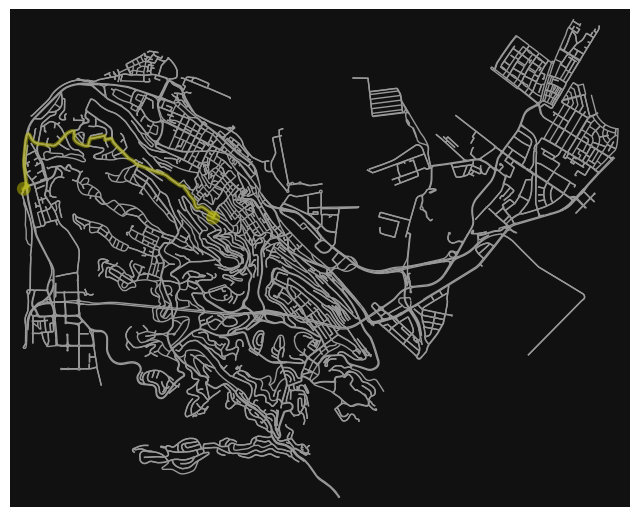

passenger route:


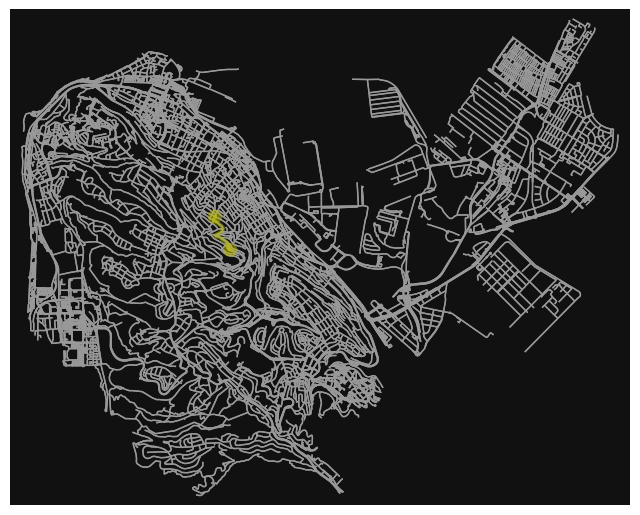

 route:


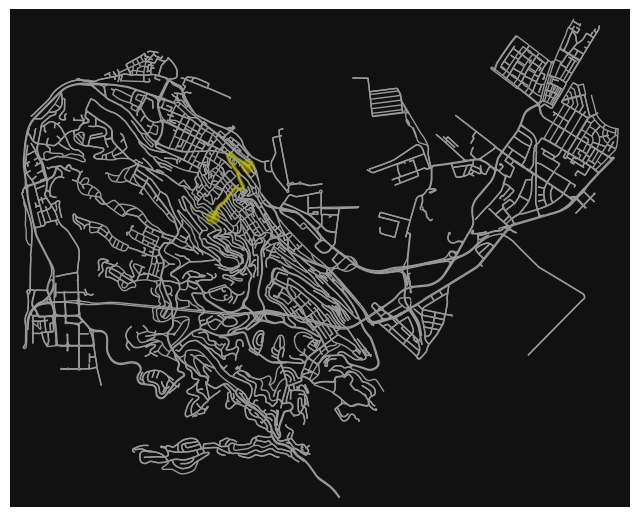

potential meeting point: Yosef, Haifa, HA ISR
displaying routes:
driver route:


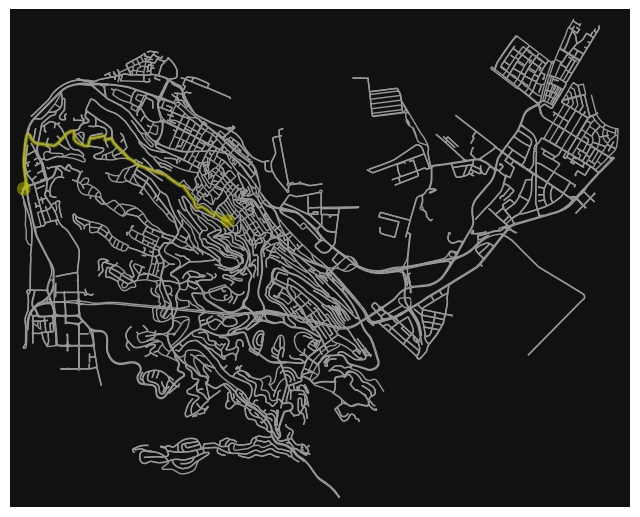

passenger route:


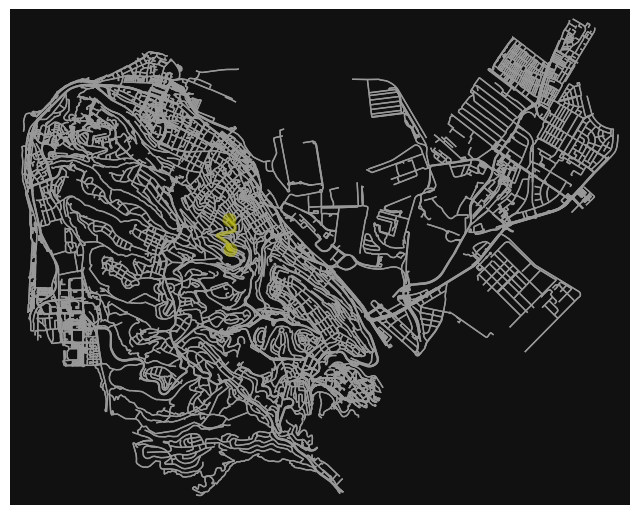

 route:


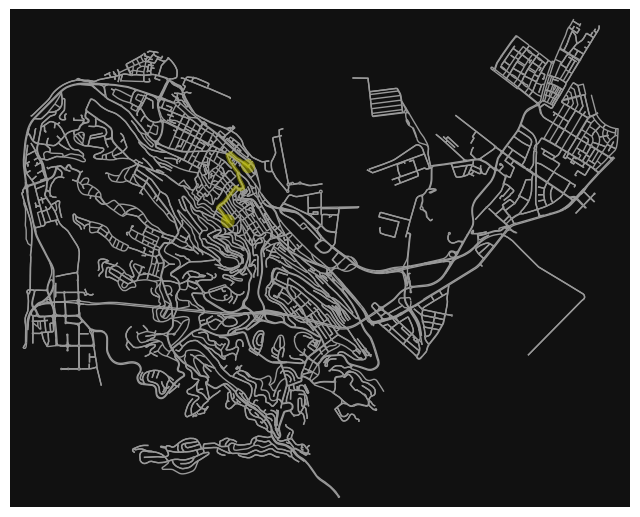

potential meeting point: Arlosoroff, Haifa, HA ISR
displaying routes:
driver route:


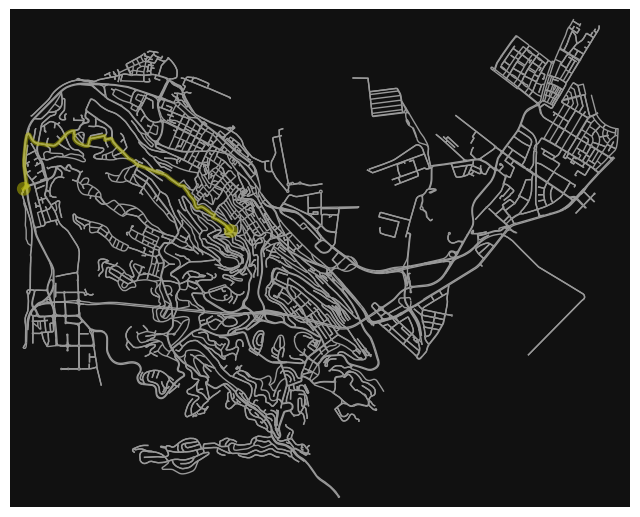

passenger route:


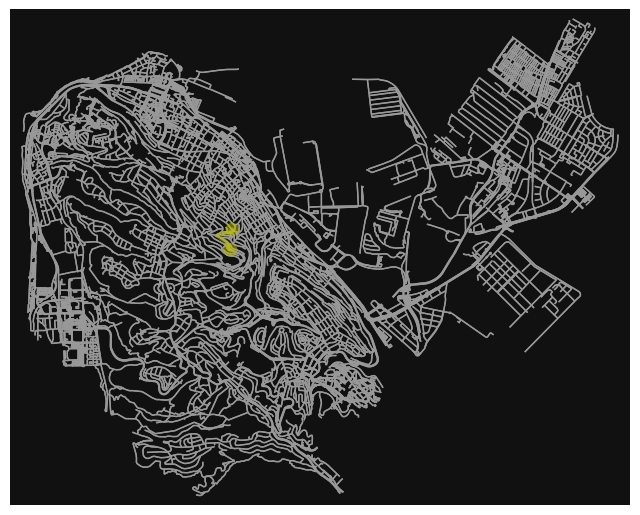

 route:


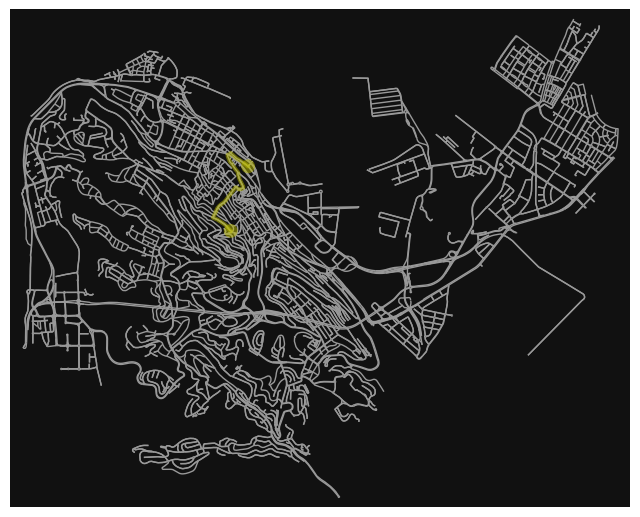

In [25]:
if dropdown_1_driver.value == dropdown_1_passenger.value and dropdown_2_driver.value == dropdown_2_passenger.value:
    for mp in mp2:
        i = mp[0]
        print("potential meeting point:",convert_coord_to_address(G,i).formattedAddress)
        print("displaying routes:")
        route = ox.shortest_path(G, driver_node, i, weight="travel_time")
        print("driver route:")
        fig, ax = ox.plot_graph_route(G, route, route_color="y", route_linewidth=3, node_size=0)
        route = ox.shortest_path(G2, passanger_node, i, weight="travel_time")
        print("passenger route:")
        fig, ax = ox.plot_graph_route(G2, route, route_color="y", route_linewidth=3, node_size=0)
        route = ox.shortest_path(G, i, destination_node, weight="travel_time")
        print(" route:")
        fig, ax = ox.plot_graph_route(G, route, route_color="y", route_linewidth=3, node_size=0)
    